In [1]:
import numpy as np
import sys
from pathlib import Path
import torch
import itertools
import gzip
import argparse
# Local includes
from src.configs.general_opts import path_opts
from src.pdb.input_output import write_precomputed

/home/dima/miniconda3/envs/amber/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt 

In [3]:
from src.features.data_encoding import numpy_structure
from src.geometry_processing import get_interface_for_pair, get_atom_features, atoms_to_points_normals
from src.geometry_processing import knn_atoms, get_atom_charge, get_point_lipophilicity

In [4]:
from src.pdb.input_output import read_bfactor

In [5]:
pid ='1FZW'
cid = 'B'

In [6]:
chain_dir =  Path(path_opts["pdb_chain_dir"])# Path("../data/data_preparation/00c_pdb_logp/")
chain_chr_dir = Path(path_opts["pdb_logps"])
# TODO add check for existing folder. If it exists, skip the computing.
comp_dir = Path(path_opts["precomputed_dir"]) / pid

In [7]:
p_filename = chain_dir / f"{pid}_{cid}.pdb"
protein_encoded = numpy_structure(str(p_filename))
xyz = protein_encoded[-1]  # coordinates

In [8]:
# TODO re-write it for tensorflow
xyz_pt = torch.Tensor(xyz)
b = torch.zeros((xyz_pt.size()[0],), dtype=torch.int8)  # batch numbers, here is only one batch.
P, n, bm = atoms_to_points_normals(xyz_pt, b)

In [9]:
all_features = np.hstack(protein_encoded[:-1])  # all features except coordinates


In [ ]:
P

In [10]:
atoms, atoms_chr = read_bfactor(pid, cid, chain_chr_dir)

/home/dima/miniconda3/envs/amber/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4621
  warnings.warn(


In [11]:
atoms_chr

array([ 0.097, -0.002,  0.721, ...,  0.167,  0.167,  0.402])

(array([2576.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0., 7908.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0., 2548.]),
 array([0.  , 0.08, 0.16, 0.24, 0.32, 0.4 , 0.48, 0.56, 0.64, 0.72, 0.8 ,
        0.88, 0.96, 1.04, 1.12, 1.2 , 1.28, 1.36, 1.44, 1.52, 1.6 , 1.68,
        1.76, 1.84, 1.92, 2.  ]),
 <BarContainer object of 25 artists>)

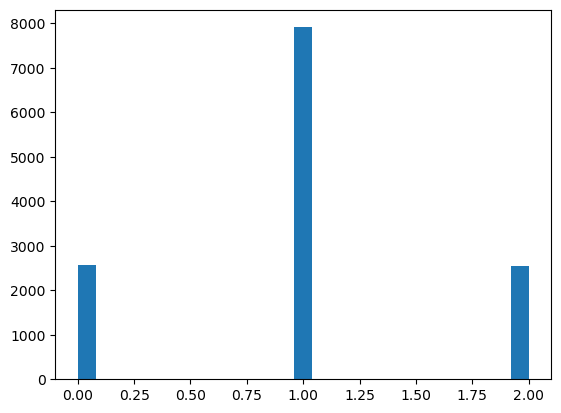

In [12]:
AA = get_point_lipophilicity(xyz_pt,P,atoms_chr)
plt.hist(AA, bins=25)

In [ ]:
P[:8]

In [ ]:
atoms[15:20]

In [ ]:
from pykeops.torch import LazyTensor


In [ ]:
x = atoms
p = P
charge = atoms_chr

In [ ]:
xx = torch.tensor([1, 2, 3,4,5])

In [ ]:
xx.repeat(3,1).T

In [ ]:
x_i = torch.Tensor(x)[:, None, :]  # (N, 1, 3) atoms
q_i = torch.Tensor(charge)[:, None]
y_j = torch.Tensor(p)[None, :, :]  # (1, M, 3) sampling points

In [ ]:
dist_ij = ((x_i - y_j) ** 2).sum(-1).sqrt()  # (N, M, 1) squared distances


In [ ]:
dist_ij[dist_ij < 2] = 1
dist_ij[dist_ij >= 2] = 0

In [ ]:
print(dist_ij.shape, q_i.shape)

In [ ]:
point_logp = torch.matmul(dist_ij.T, q_i)
point_logp = point_logp.squeeze(dim=1)

In [ ]:
levels = np.ones(point_logp.shape[0], dtype=int)
levels[point_logp > 0.3] = 2
levels[point_logp < -0.3] = 0

In [ ]:
plt.hist(levels)